In [1]:
import os
import glob
import datetime
import importlib
import statistics
import numpy as np
import pandas as pd
from marcap import marcap_data
import FinanceDataReader as fdr
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from prettytable import PrettyTable

In [2]:
import models.qp as model # import get_stocks # 1/PBR + GP/A
#import models.ncav as model # NCAV
#import models.super_value as model # PBR + PCR + PER + PSR
#import models.super_quality as model

importlib.reload(model)

<module 'models.qp' from '/Users/seunghun/Documents/Projects/stock-backtesting/backtest-playground/quantitative-value/models/qp.py'>

In [7]:
MODEL_NAME = 'qp'
DATA_DIR = '../data/daily/8-1'

In [8]:
df_account = pd.DataFrame(columns=['start_date', 'end_date', 'filepath'])
filepaths = glob.glob(DATA_DIR + "/*.csv")
filepaths = sorted(filepaths)

days = []
for i in range(len(filepaths)):
    if i < len(filepaths) - 1: # exclude last item
        start_date =  os.path.basename(filepaths[i])[:-4]
        end_date =  os.path.basename(filepaths[i + 1])[:-4]
        
        day = {'start_date':start_date, 'end_date':end_date, 'filepath':filepaths[i]}
        days.append(day)

df_account = df_account.append(days)

In [9]:
df_account

,start_date,end_date,filepath
0,1999-08-02,2000-08-01,../data/daily/8-1/1999-08-02.csv
1,2000-08-01,2001-08-01,../data/daily/8-1/2000-08-01.csv
2,2001-08-01,2002-08-01,../data/daily/8-1/2001-08-01.csv
3,2002-08-01,2003-08-01,../data/daily/8-1/2002-08-01.csv
4,2003-08-01,2004-08-02,../data/daily/8-1/2003-08-01.csv
5,2004-08-02,2005-08-01,../data/daily/8-1/2004-08-02.csv
6,2005-08-01,2006-08-01,../data/daily/8-1/2005-08-01.csv
7,2006-08-01,2007-08-01,../data/daily/8-1/2006-08-01.csv
8,2007-08-01,2008-08-01,../data/daily/8-1/2007-08-01.csv
9,2008-08-01,2009-08-03,../data/daily/8-1/2008-08-01.csv


In [10]:
# 연도별 종목을 구한다.
df_account['stocks'] = df_account.apply(lambda x: model.get_stocks(x.filepath, x.start_date, False), axis=1)

1999-08-02 선정 기업 수 30
2000-08-01 선정 기업 수 30
2001-08-01 선정 기업 수 30
2002-08-01 선정 기업 수 30
2003-08-01 선정 기업 수 30
2004-08-02 선정 기업 수 30
2005-08-01 선정 기업 수 30
2006-08-01 선정 기업 수 30
2007-08-01 선정 기업 수 30
2008-08-01 선정 기업 수 30
2009-08-03 선정 기업 수 30
2010-08-02 선정 기업 수 30
2011-08-01 선정 기업 수 30
2012-08-01 선정 기업 수 30
2013-08-01 선정 기업 수 30
2014-08-01 선정 기업 수 30
2015-08-03 선정 기업 수 30
2016-08-01 선정 기업 수 30
2017-08-01 선정 기업 수 30
2018-08-01 선정 기업 수 30


In [11]:
# 연도별 수익률을 구한다.
df_account['yield'] = 0.0
df_account['yields'] = 0.0
df_account['yields'] = df_account['yields'].astype('object')
df_account['delisted'] = 0
df_account['delisted_stocks'] = df_account['yields'].astype('object')

for i in range(len(filepaths)):
    if i < len(filepaths) - 1: # exclude last item
        start_date = df_account.iloc[i].start_date
        end_date = df_account.iloc[i].end_date
        
        df_this_year = pd.read_csv(filepaths[i], dtype={"기업코드":"string", "종목코드":"string"})[['종목코드', '주가']]
        df_next_year = pd.read_csv(filepaths[i + 1], dtype={"기업코드":"string", "종목코드":"string"})[['종목코드', '주가']]
        
        stocks = df_account.iloc[i].stocks   
        yields = []
        
        # 종목별 수익률, 상장폐지 기업 수를 구한다.
        delisted = 0 # 상장폐지 기업 수
        delisted_stocks  = []
        for stock in stocks:
            start_price = df_this_year[df_this_year['종목코드'] == stock]['주가'].iloc[0]
            end_price = df_next_year[df_next_year['종목코드'] == stock]['주가']
            
            if len(end_price) == 0:
                end_price = 0
            else:                    
                end_price = end_price.fillna(0) 
                end_price = end_price.iloc[0]
                
            if end_price == 0: # 가격 정보가 없을 경우 상폐
                delisted += 1
                delisted_stocks.append(stock)
            
            # get yield
            yields.append(end_price / start_price)

        # stock 수익률들의 avg가 total 수익률이 된다. (동일 비중이기 때문에)
        mean_yields = statistics.mean(yields)
        df_account.at[i, 'yield'] = mean_yields
        df_account.at[i, 'yields'] = yields
        df_account.at[i, 'delisted'] = delisted
        df_account.at[i, 'delisted_stocks'] = delisted_stocks
        
        print(start_date, '~', end_date, ":", mean_yields)
        
        #break

1999-08-02 ~ 2000-08-01 : 1.830436080275424
2000-08-01 ~ 2001-08-01 : 2.0254746474930188
2001-08-01 ~ 2002-08-01 : 1.177830035701309
2002-08-01 ~ 2003-08-01 : 0.8800222476661446
2003-08-01 ~ 2004-08-02 : 1.046178849695229
2004-08-02 ~ 2005-08-01 : 2.853786099662451
2005-08-01 ~ 2006-08-01 : 1.2004020671638218
2006-08-01 ~ 2007-08-01 : 2.2368028664141812
2007-08-01 ~ 2008-08-01 : 0.8694899215130552
2008-08-01 ~ 2009-08-03 : 1.1459746697578597
2009-08-03 ~ 2010-08-02 : 1.4444868681776335
2010-08-02 ~ 2011-08-01 : 2.2063302078359066
2011-08-01 ~ 2012-08-01 : 1.4617654555959863
2012-08-01 ~ 2013-08-01 : 1.2986769460409477
2013-08-01 ~ 2014-08-01 : 1.304503631641778
2014-08-01 ~ 2015-08-03 : 2.0560129586739726
2015-08-03 ~ 2016-08-01 : 1.578267452323414
2016-08-01 ~ 2017-08-01 : 1.0330638832475
2017-08-01 ~ 2018-08-01 : 1.8637263534525885
2018-08-01 ~ 2019-08-01 : 1.2932781105476583


In [12]:
df_account['total'] = df_account['yield'].cumprod()

In [13]:
df_account['cagr'] = 0.0
for i, row in enumerate(df_account.iterrows()):
    df_account.at[i, 'cagr'] = pow(row[1]['total'], 1/(i+1))

In [14]:
def get_win_rate(yield_rates):
    return sum([yield_rate > 1.0 for yield_rate in yield_rates]) / len(yield_rates)

df_account['win_rate'] = df_account.apply(lambda x: get_win_rate(x['yields']), axis=1)

In [15]:
df_account['best_corp'] = df_account.apply(lambda x: max(x['yields']), axis=1)
df_account['worst_corp'] = df_account.apply(lambda x: min(x['yields']), axis=1)

In [16]:
df_account['best_stock_code'] = df_account.apply(lambda x: x['stocks'][np.argmax(x['yields'])], axis=1)
df_account['worst_stock_code'] = df_account.apply(lambda x: x['stocks'][np.argmin(x['yields'])], axis=1)

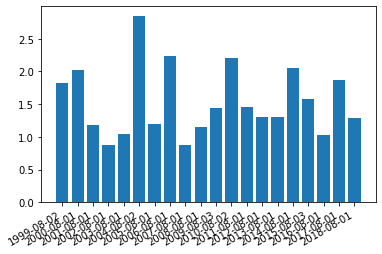

In [17]:
fig, ax = plt.subplots()
plt.bar(df_account['start_date'], df_account['yield'])
fig.autofmt_xdate()
plt.show()

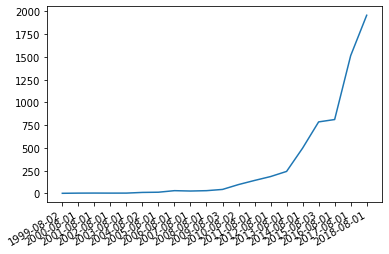

In [18]:
fig, ax = plt.subplots()
ax.plot_date(df_account['start_date'], df_account['total'], marker='', linestyle='-')
fig.autofmt_xdate()
plt.show()

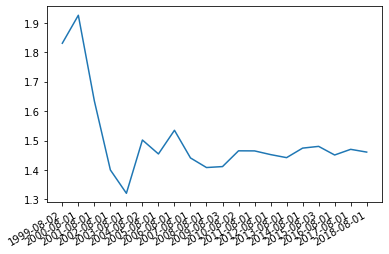

In [19]:
fig, ax = plt.subplots()
ax.plot_date(df_account['start_date'], df_account['cagr'], marker='', linestyle='-')
fig.autofmt_xdate()
plt.show()

In [20]:
1 - min(df_account['yield'])

0.13051007848694485

In [21]:
max(df_account['yield'])

2.853786099662451

In [22]:
# 가격 정보가 없는 경우 상폐로 처리했음. 실제로 상폐까지는 아니고 거래정지인 경우가 있음
sum(df_account['delisted'])

11

In [23]:
df_account

,start_date,end_date,filepath,stocks,yield,yields,delisted,delisted_stocks,total,cagr,win_rate,best_corp,worst_corp,best_stock_code,worst_stock_code
0,1999-08-02,2000-08-01,../data/daily/8-1/1999-08-02.csv,"[028090, 023900, 008040, 002140, 004910, 00052...",1.830436,"[3.66023166023166, 3.84375, 0.0814569536423841...",0,[],1.830436,1.830436,0.466667,8.298319,0.081457,003310,008040
1,2000-08-01,2001-08-01,../data/daily/8-1/2000-08-01.csv,"[005610, 014300, 008870, 005390, 027390, 00396...",2.025475,"[3.5989717223650386, 1.0658307210031348, 2.171...",0,[],3.707502,1.925487,0.766667,6.244186,0.667665,014280,003960
2,2001-08-01,2002-08-01,../data/daily/8-1/2001-08-01.csv,"[008900, 017680, 036580, 004540, 003230, 00214...",1.177830,"[1.0277777777777777, 1.7096774193548387, 1.197...",0,[],4.366807,1.634512,0.600000,2.700000,0.134676,009460,006890
3,2002-08-01,2003-08-01,../data/daily/8-1/2002-08-01.csv,"[010600, 008900, 005610, 025880, 003230, 01457...",0.880022,"[0.8875739644970414, 0.27522522522522525, 0.66...",0,[],3.842887,1.400117,0.233333,1.426829,0.275225,027040,008900
4,2003-08-01,2004-08-02,../data/daily/8-1/2003-08-01.csv,"[010600, 009460, 003680, 014100, 025880, 00409...",1.046179,"[0.7766666666666666, 0.7991803278688525, 2.113...",0,[],4.020347,1.320848,0.333333,5.214724,0.377982,006090,018680
5,2004-08-02,2005-08-01,../data/daily/8-1/2004-08-02.csv,"[010600, 017680, 005320, 032860, 016920, 00409...",2.853786,"[1.6251788268955651, 1.96875, 1.30087390761548...",0,[],11.473212,1.501807,1.000000,20.588235,1.256545,050050,045060
6,2005-08-01,2006-08-01,../data/daily/8-1/2005-08-01.csv,"[010600, 017680, 007980, 046310, 005320, 01447...",1.200402,"[2.183098591549296, 1.812169312169312, 1.10526...",1,[005320],13.772467,1.454507,0.733333,3.692130,0.000000,014470,005320
7,2006-08-01,2007-08-01,../data/daily/8-1/2006-08-01.csv,"[068290, 007980, 025880, 000440, 008110, 01692...",2.236803,"[2.0201729106628243, 2.3579109062980033, 1.865...",0,[],30.806294,1.534899,1.000000,5.096045,1.235023,004090,024940
8,2007-08-01,2008-08-01,../data/daily/8-1/2007-08-01.csv,"[017680, 006060, 010600, 045060, 079650, 02588...",0.869490,"[0.5589519650655022, 0.7112195121951219, 0.043...",0,[],26.785762,1.440974,0.266667,2.293144,0.043750,009470,010600
9,2008-08-01,2009-08-03,../data/daily/8-1/2008-08-01.csv,"[038320, 011080, 005320, 006060, 078520, 01457...",1.145975,"[0.37209302325581395, 0.6292517006802721, 0.98...",0,[],30.695805,1.408341,0.300000,3.630252,0.230814,078520,005360


In [24]:
#df_account.to_csv('log/' + MODEL_NAME + '-' + os.path.basename(DATA_DIR) + '.csv', index=False)